# 데이터

In [1]:
import numpy as np

import matplotlib.pyplot as plt

Sequence

In [2]:
def makeSequence(data, inSeq_len, outSeq_len):
  Xs = []
  Ys = []
  for i in range(len(data) + 1 - (inSeq_len+outSeq_len)):
    x = data[i:i+inSeq_len]
    y = data[i+inSeq_len: i+inSeq_len+outSeq_len]

    Xs.append(x)
    Ys.append(y)

  Xs = np.array(Xs).reshape(len(Xs), inSeq_len, -1)
  Ys = np.array(Ys).reshape(len(Xs), inSeq_len, -1)

  return Xs, Ys

In [76]:
''' random data gen'''
x = np.arange(0, 1000, 0.5)
y1 = np.random.rand(len(x))
y2 = 3*np.sin(np.pi/180*30*x)
y = y1+y2

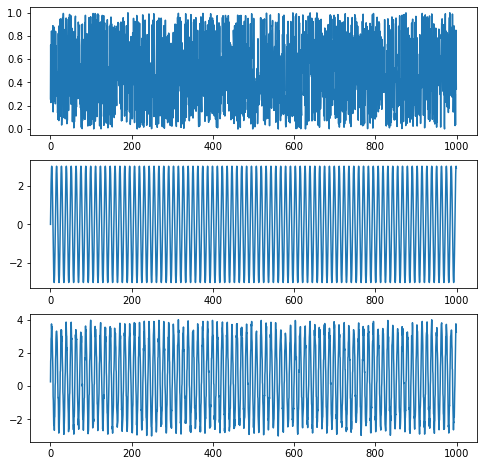

In [77]:
''' data check'''
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(x, y1)
axs[1].plot(x, y2)
axs[2].plot(x, y)
plt.show()

In [78]:
''' make Sequence'''
Xs, Ys = makeSequence(y, 20, 20)
print(Xs.shape)
print(Ys.shape)

(1961, 20, 1)
(1961, 20, 1)


In [79]:
train_data_num = int(len(Xs)*0.8)
print(train_data_num)
trainX = Xs[:train_data_num]
trainY = Ys[:train_data_num]
testX = Xs[:train_data_num]
testY = Ys[:train_data_num]

print(trainX.shape)

1568
(1568, 20, 1)


In [80]:
batch_size = 16



# 모델

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim

In [82]:
trainX = torch.Tensor(trainX)
trainY = torch.Tensor(trainY)
testX = torch.Tensor(testX)
testY = torch.Tensor(testY)

In [83]:
print(trainX.shape)

torch.Size([1568, 20, 1])


In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [85]:
class RNN(nn.Module):
  def __init__(self, input_dim=1, hidden_dim=32, target_dim=1):
    super().__init__()
    self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
    self.hidden2pred = nn.Linear(hidden_dim, target_dim)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    net_out = self.hidden2pred(lstm_out)
    
    return net_out

net = RNN().to(device)

In [86]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.5, 0.999))

In [87]:
epochs = 100
batch_size = 16
disp_rate = 1000
losses = []
for epoch in range(epochs):
  running_loss = 0.0
  for j in range(0, len(trainX), batch_size):
    trainX_in = trainX[j:j+batch_size]
    trainY_in = trainY[j:j+batch_size]

    inputs, labels = trainX_in.to(device), trainY_in.to(device) 

    optimizer.zero_grad()
    
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    losses.append(loss)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if j % disp_rate == disp_rate-1:
      print(f"epochs: {epoch+1:3}, batches: {j+1:6}, loss: {running_loss/disp_rate:.3f}")
      running_loss = 0.0

print('Finished training')

Finished training


In [89]:
trueY_cpu = testY.numpy()

outputs_cpu = outputs.to("cpu")
outputs_np = outputs_cpu.detach().numpy()
print(outputs_np.shape)

(1568, 20, 1)


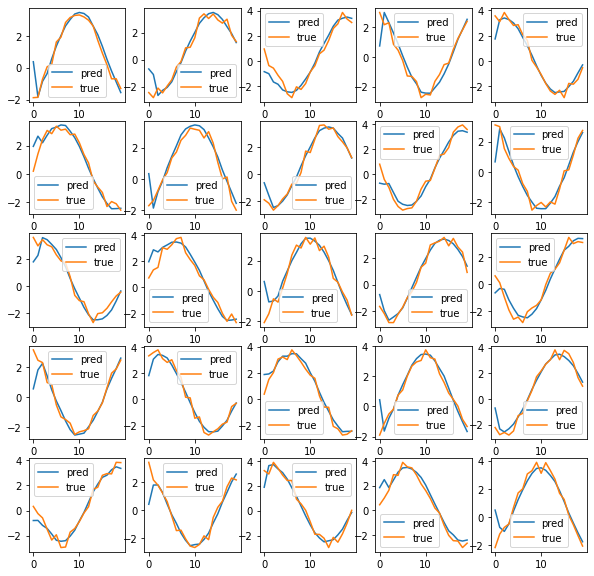

In [91]:
plt.figure(figsize=(10,10))
for i in range(5):
  for j in range(5):
    plt.subplot(5, 5, 5*i + j + 1)
    plt.plot(outputs_np[(5*i + j)*20], label='pred')
    plt.plot(trueY_cpu[(5*i + j)*20], label='true')
    plt.legend()

plt.show()